# Random Forest Modeling
## Continuous Response (view_count)

In [4]:
# import/install librares/packages
!pip install pandas numpy scikit-learn statsmodels xgboost matplotlib seaborn
!pip install -U scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import max_error, mean_absolute_error, precision_score, f1_score

# initialize scaler
scaler = StandardScaler()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [22]:
# read in data
music = pd.read_csv("model_ready_dataset.csv")
print(music.dtypes)
music.head(2)

acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
                                   ...   
Life_Nostalgia_Topic              float64
Party_Dance_Sensuality_Topic      float64
Love_Emotion_Sentiment_Topic      float64
Loss_Struggle_Reflection_Topic    float64
Energy_Vibes_Epic_Topic           float64
Length: 61, dtype: object


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,view_count,...,avg_word_len,unique_words,vocab_richness,Rap_Street_Slang_Topic,Romance_Relationships_Topic,Life_Nostalgia_Topic,Party_Dance_Sensuality_Topic,Love_Emotion_Sentiment_Topic,Loss_Struggle_Reflection_Topic,Energy_Vibes_Epic_Topic
0,0.2020,0.759,0.699,0.000131,0.4430,-5.745,0.0307,92.960,0.907,1.118930e+09,...,4.846395,98,0.307210,0.001245,0.001247,0.001247,0.362314,0.385711,0.001244,0.246992
1,0.0393,0.535,0.505,0.000000,0.0923,-8.926,0.2450,99.935,0.495,2.205607e+08,...,5.327024,428,0.450053,0.192193,0.030384,0.000396,0.015850,0.760386,0.000396,0.000396


In [6]:
# features
X = music.drop(columns=['view_count'])

# numeric columns only
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[num_cols]

# scale numeric columns
X = scaler.fit_transform(X_numeric)

# target
y = music['view_count']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

/tmp/ipykernel_644224/1326071553.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vocab = music.groupby('view_bin')['Rap_Street_Slang_Topic'].mean().reset_index()


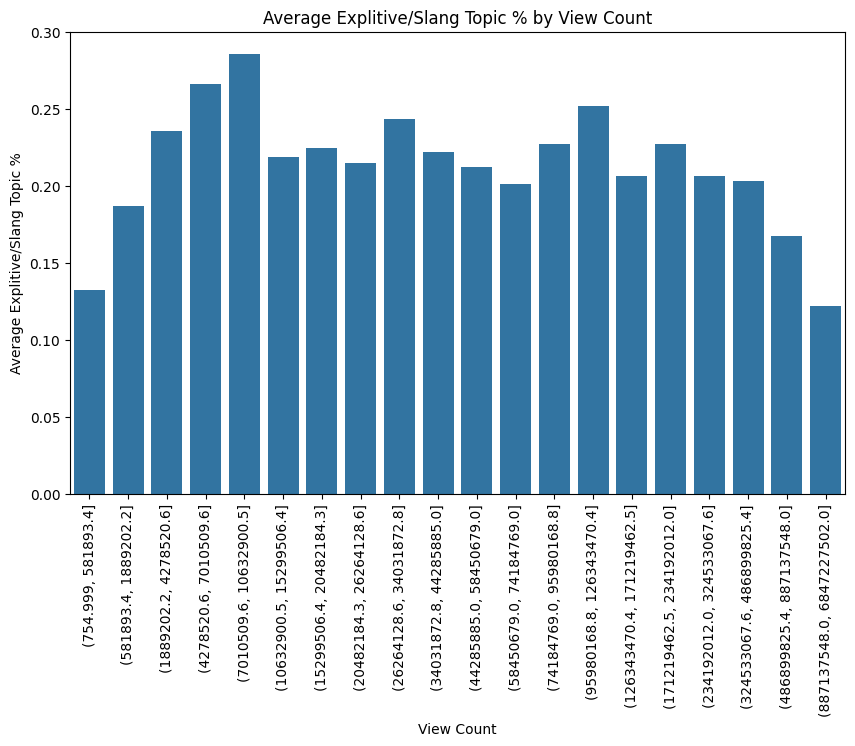

In [55]:
import pandas as pd
music['view_bin'] = pd.qcut(music['view_count'], 20)  # 20 quantile bins
avg_vocab = music.groupby('view_bin')['Rap_Street_Slang_Topic'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='view_bin', y='Rap_Street_Slang_Topic', data=avg_vocab)
plt.xticks(rotation=90)
plt.xlabel("View Count")
plt.ylabel("Average Explitive/Slang Topic %")
plt.title("Average Explitive/Slang Topic % by View Count")
plt.show()

In [17]:
# parameter grid
grid_param = {
    'n_estimators': [550, 600, 700],
    'max_depth': [None, 2], 
    'min_samples_split': [6, 8, 10], 
    'min_samples_leaf': [4]
}

rf = RandomForestRegressor(
    random_state=1234
)

In [18]:
# set grid search
gd_sr = GridSearchCV(
    estimator=rf,
    param_grid=grid_param,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# fit grid search
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [None, 2], 'min_samples_leaf': [4],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [550, 600, 700]},
             scoring='r2')

In [19]:
# best parameters / score
best_parameters = gd_sr.best_params_
print("Best Parameters:", best_parameters)

best_result = gd_sr.best_score_
print("Best CV R2 Score:", best_result)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 700}
Best CV R2 Score: 0.16302145543065372


In [9]:
# fit best model
regressor = RandomForestRegressor(
    random_state=1234,
    n_estimators = 700,
    max_depth = None,
    min_samples_split = 6,
    min_samples_leaf = 4
)

regressor.fit(X_train, y_train)

# predict on test data and compute error metrics
y_pred = regressor.predict(X_test)

print("max error: ", max_error(y_test, y_pred))
print("mean absolute error: ", mean_absolute_error(y_test, y_pred))
print("mean squared error: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

max error:  6647943894.256856
mean absolute error:  203672906.30525407
mean squared error:  1.637611126036495e+17
r2 score:  0.1503816636943286


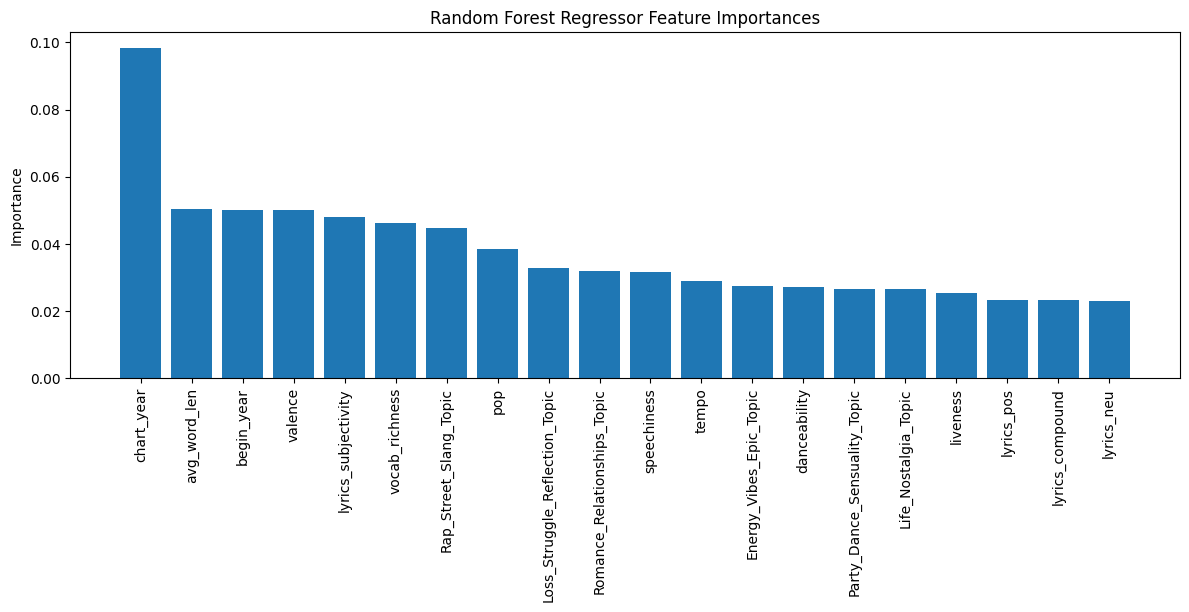

In [21]:
# get feature importance for rf model and view
importances = regressor.feature_importances_
feature_names = X_numeric.columns

# sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices][:20], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.title("Random Forest Regressor Feature Importances")
plt.show()

## Binary Response (Viral vs. Not Viral)

In [17]:
# create binary target
music['viral'] = (music['view_count'] > 100000000).astype(int)

# features
X = music.drop(columns=['view_count','viral'])

# numeric columns only
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[num_cols]

# scale numeric columns
X = scaler.fit_transform(X_numeric)

# target
y = music['viral']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [10]:
# parameter grid
grid_param = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 5, 7, 9], 
    'min_samples_split': [8, 10, 12], 
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(
    random_state=1234
)

In [11]:
# set grid search
gd_sr = GridSearchCV(
    estimator=rf,
    param_grid=grid_param,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# fit grid search
gd_sr.fit(X_train, y_train)

print("Best Parameters:", gd_sr.best_params_)
print("Best CV ROC AUC:", gd_sr.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}
Best CV ROC AUC: -0.24695929845613535


In [36]:
# fit best model
classifier = RandomForestClassifier(
    random_state=1234,
    n_estimators = 400,
    max_depth = None,
    min_samples_split = 10,
    min_samples_leaf = 2
)

classifier.fit(X_train, y_train)

# predicted probabilities
y_prob = classifier.predict_proba(X_test)[:, 1]

# predicted class
y_pred = classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7103150092649784
Precision: 0.7419354838709677
Recall: 0.2804878048780488
F1 Score: 0.40707964601769914
ROC AUC: 0.755048930530317
Confusion Matrix:
 [[989  56]
 [413 161]]


In [37]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Candidate thresholds
thresholds = np.arange(0.1, 0.91, 0.01)

f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best Threshold for F1 Score:", best_threshold)
print("Best F1 Score:", f1_scores[best_idx])

Best Threshold for F1 Score: 0.30999999999999994
Best F1 Score: 0.6178428761651131


In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Predictions at best threshold
y_pred_opt = (y_prob >= best_threshold).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_opt)
print("Accuracy at best threshold:", accuracy)

# ROC AUC (still uses probabilities, not thresholded predictions)
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)

Accuracy at best threshold: 0.6454601605929586
ROC AUC: 0.755048930530317


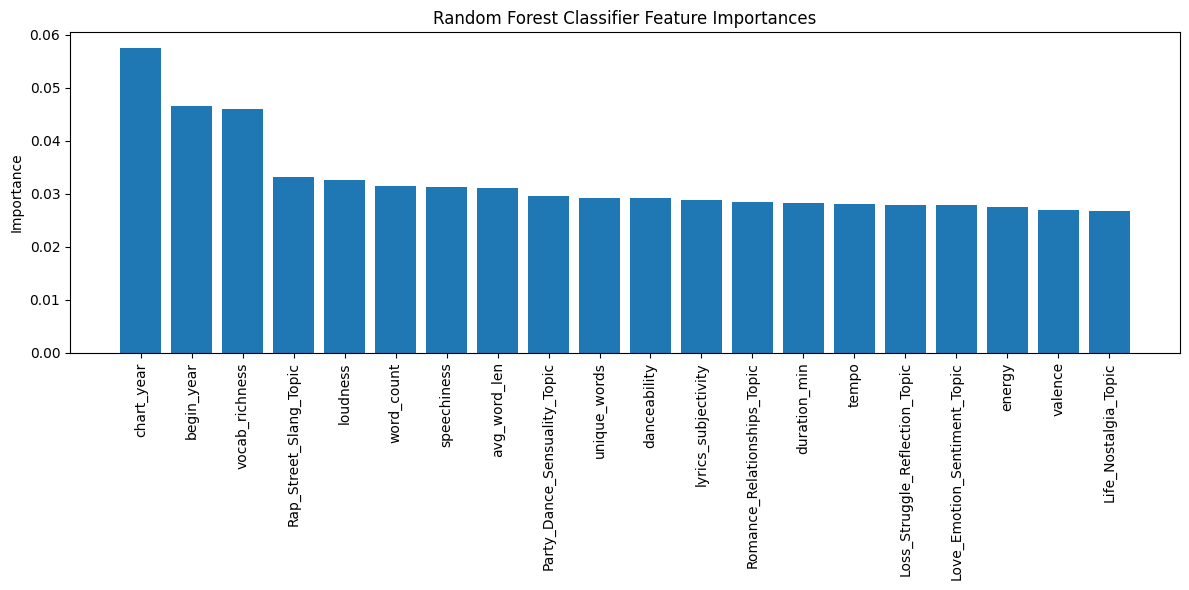

In [19]:
# feature importance plot
importances = classifier.feature_importances_
feature_names = X_numeric.columns 

# sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest Classifier Feature Importances")
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices][:20], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()